In [5]:
#pip install pandas-datareader

# Анализ Зависимость индекса Мосбиржи и отдельных эмитентов входящих в индекс от цен на нефть и цен на драг. металы

Цель данной работы проанализировать зависимость биржевой цены индекса Мосбиржи от цены на нефть и цены на золото, а также построить уравнение линейной регрессии (если возможно) для предсказания данных. Все данные взяты из открытого источника yahho.finance

In [327]:
from pandas_datareader import data as dr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

# 1. Создание DataSet

In [328]:
tickers = ['IMOEX.ME','CL=F','GC=F','GAZP.ME','ALRS.ME','SBER.ME','AFLT.ME']

start_date ='2015-01-01'
end_date = '2020-03-31'

data = dr.DataReader(tickers,'yahoo', start_date, end_date)

Описание датасета:

'IMOEX.ME'- индекс Мосбиржы,

'CL=F'- нефть Brent USD

'GC=F' золото

'GAZP.ME'- Газпром

'ALRS.ME' -Алроса

'SBER.ME' - Сбербанк 

'AFLT.ME' -аэрофлот




In [329]:
data.head()

Attributes Adj Close                                                           \
Symbols     IMOEX.ME       CL=F         GC=F    GAZP.ME    ALRS.ME    SBER.ME   
Date                                                                            
2014-12-31       NaN  53.270000  1183.900024        NaN        NaN        NaN   
2015-01-02       NaN  52.689999  1186.000000        NaN        NaN        NaN   
2015-01-05       NaN  50.040001  1203.900024  92.627869  35.736744  46.858410   
2015-01-06       NaN  47.930000  1219.300049  96.064682  36.269421  48.446125   
2015-01-07       NaN  48.650002  1210.599976        NaN        NaN        NaN   

Attributes               Close                          ...       Open  \
Symbols       AFLT.ME IMOEX.ME       CL=F         GC=F  ...    ALRS.ME   
Date                                                    ...              
2014-12-31        NaN      NaN  53.270000  1183.900024  ...        NaN   
2015-01-02        NaN      NaN  52.689999  1186.000000  ...        NaN   
2015-01-05  27.113356      NaN  50.040001  1203.900024  ...  63.950001   
2015-01-06  26.999054      NaN  47.930000  1219.300049  ...  60.200001   
2015-01-07        NaN      NaN  48.650002  1210.599976  ...        NaN   

Attributes                      Volume                               \
Symbols    SBER.ME    AFLT.ME IMOEX.ME      CL=F   GC=F     GAZP.ME   
Date                                                                  
2014-12-31     NaN        NaN      NaN  218557.0  191.0         NaN   
2015-01-02     NaN        NaN      NaN  233516.0   92.0         NaN   
2015-01-05   54.02  31.250000      NaN  268708.0  138.0  18223370.0   
2015-01-06   56.00  32.959999      NaN  375782.0  470.0  25297090.0   
2015-01-07     NaN        NaN      NaN  451642.0   97.0         NaN   

Attributes                                   
Symbols       ALRS.ME     SBER.ME   AFLT.ME  
Date                                         
2014-12-31        NaN         NaN       NaN  
2015-01-02        NaN         NaN       NaN  
2015-01-05  4150300.0  63231040.0  982201.0  
2015-01-06  2560045.0  70269700.0  768000.0  
2015-01-07        NaN         NaN       NaN  

[5 rows x 42 columns]

в данной работе оценка идет по цене закрытия остальные колонки выкидываеи

In [330]:
data=data['Close']
data.head()

Symbols,IMOEX.ME,CL=F,GC=F,GAZP.ME,ALRS.ME,SBER.ME,AFLT.ME
Date,,,,,,,
2014-12-31,NaN,53.270000,1183.900024,NaN,NaN,NaN,NaN
2015-01-02,NaN,52.689999,1186.000000,NaN,NaN,NaN,NaN
2015-01-05,NaN,50.040001,1203.900024,133.949997,60.380001,56.369999,33.209999
2015-01-06,NaN,47.930000,1219.300049,138.919998,61.279999,58.279999,33.070000
2015-01-07,NaN,48.650002,1210.599976,NaN,NaN,NaN,NaN


нулевые значения связаны с графиками работы бирж т.к выборка достаточно большая также удаляем нулевые значения

In [331]:
data=data[data['IMOEX.ME'].notnull()]
data=data[data['CL=F'].notnull()]
data=data[data['GC=F'].notnull()]
data.head()

Symbols,IMOEX.ME,CL=F,GC=F,GAZP.ME,ALRS.ME,SBER.ME,AFLT.ME
Date,,,,,,,
2015-01-16,1591.430054,48.689999,1276.900024,149.600006,69.550003,61.990002,36.049999
2015-01-20,1570.969971,46.389999,1294.199951,145.750000,71.000000,60.799999,37.200001
2015-01-21,1618.170044,47.779999,1293.699951,148.800003,76.500000,62.799999,38.099998
2015-01-22,1666.560059,46.310001,1300.699951,151.500000,77.500000,64.349998,39.549999
2015-01-23,1671.800049,45.590000,1292.599976,152.830002,76.000000,64.449997,40.150002


получен итоговый датасет

# 2. Анализ датасета

In [332]:
data.describe()

Symbols,IMOEX.ME,CL=F,GC=F,GAZP.ME,ALRS.ME,SBER.ME,AFLT.ME
count,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000
mean,2168.484442,52.653504,1280.038893,157.070297,81.335549,169.141379,107.758196
std,390.110606,9.644295,118.992423,35.929387,13.487217,59.671364,47.209092
min,1570.969971,20.280001,1050.800049,115.349998,48.959999,60.490002,32.500000
25%,1879.695007,46.690001,1206.350037,136.555000,71.650002,121.014999,76.160000
50%,2098.149902,52.240002,1267.199951,145.000000,81.250000,174.600006,104.480003
75%,2403.944946,58.815001,1321.500000,158.459999,92.614998,222.245003,140.399994
max,3209.219971,76.410004,1696.099976,270.739990,107.699997,280.470001,225.000000


средне квадратичное отклонение

In [333]:
data.describe().std()

Symbols
IMOEX.ME    835.588764
CL=F        425.413213
GC=F        454.134483
GAZP.ME     394.688811
ALRS.ME     416.777527
SBER.ME     393.284668
AFLT.ME     408.246812
dtype: float64

Дисперсия

In [334]:
data.describe().var()

Symbols
IMOEX.ME    698208.582151
CL=F        180976.401829
GC=F        206238.128630
GAZP.ME     155779.257809
ALRS.ME     173703.506612
SBER.ME     154672.830160
AFLT.ME     166665.459129
dtype: float64

In [335]:
def show_plot(index_name):
    plt.figure(figsize = (8, 4))

    plt.subplot(121)
    data[index_name].hist()
    plt.ylabel('count')
    plt.xlabel(index_name)

    plt.subplot(122)
    sns.kdeplot(data[index_name], shade=True, legend=False)
    plt.xlabel(index_name)

    plt.suptitle('Distribution of '+ index_name)


    plt.show()

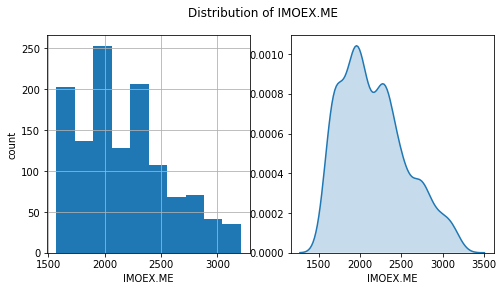

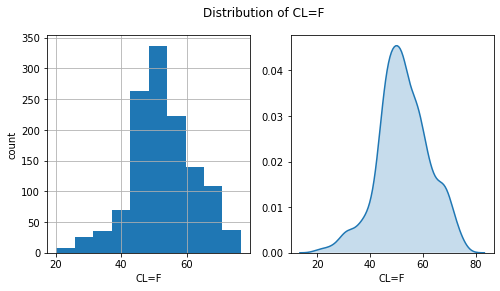

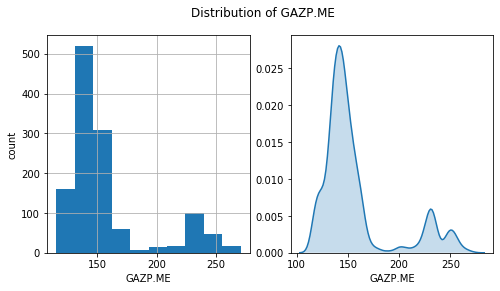

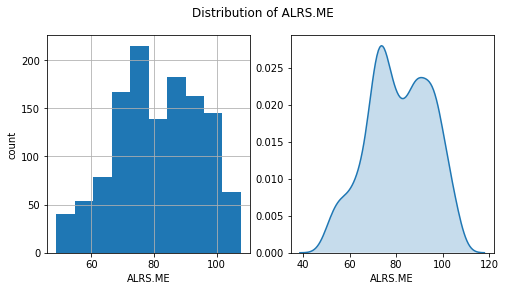

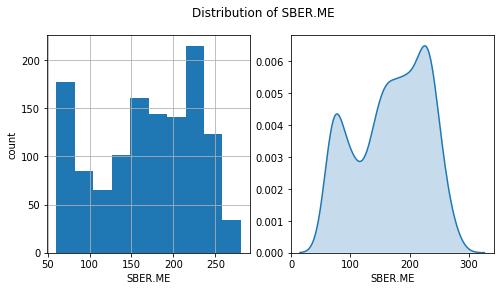

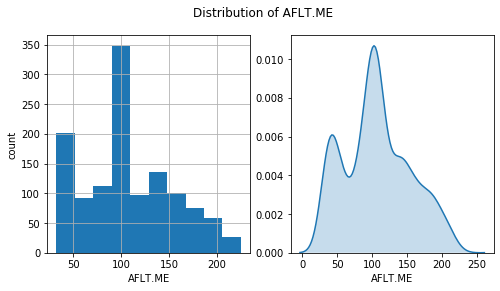

In [336]:
show_plot('IMOEX.ME')
show_plot('CL=F')
show_plot('GAZP.ME')
show_plot('ALRS.ME')
show_plot('SBER.ME')
show_plot('AFLT.ME')

коэффицент корреляции Пирсона

In [337]:
data.corr()

Symbols,IMOEX.ME,CL=F,GC=F,GAZP.ME,ALRS.ME,SBER.ME,AFLT.ME
Symbols,,,,,,,
IMOEX.ME,1.000000,0.458319,0.765463,0.805626,0.460002,0.877502,0.273406
CL=F,0.458319,1.000000,0.140387,0.212504,0.575740,0.553099,0.252953
GC=F,0.765463,0.140387,1.000000,0.698424,0.102775,0.667566,0.218590
GAZP.ME,0.805626,0.212504,0.698424,1.000000,0.026109,0.494407,-0.167236
ALRS.ME,0.460002,0.575740,0.102775,0.026109,1.000000,0.559190,0.575017
SBER.ME,0.877502,0.553099,0.667566,0.494407,0.559190,1.000000,0.571719
AFLT.ME,0.273406,0.252953,0.218590,-0.167236,0.575017,0.571719,1.000000


коэффицент корреляции Кендала

In [338]:
data.corr(method='kendall')

Symbols,IMOEX.ME,CL=F,GC=F,GAZP.ME,ALRS.ME,SBER.ME,AFLT.ME
Symbols,,,,,,,
IMOEX.ME,1.000000,0.402847,0.486152,0.475732,0.399015,0.781338,0.232104
CL=F,0.402847,1.000000,0.162490,0.234575,0.377134,0.445370,0.168519
GC=F,0.486152,0.162490,1.000000,0.236627,0.062390,0.499630,0.200528
GAZP.ME,0.475732,0.234575,0.236627,1.000000,0.102370,0.285984,-0.184582
ALRS.ME,0.399015,0.377134,0.062390,0.102370,1.000000,0.332371,0.402093
SBER.ME,0.781338,0.445370,0.499630,0.285984,0.332371,1.000000,0.390326
AFLT.ME,0.232104,0.168519,0.200528,-0.184582,0.402093,0.390326,1.000000


т.к все используемые методы работают на нормальных распределениях то

Проверим распределения на нормальность

Функция проверки на нормальность по тесту Колмогорова-Смирнова

In [339]:
def test_for_normal(index_name,alfa):
    #cdf - теоретическая функция нормального распределения для выборки index_name
    cdf = stats.norm(loc=data[index_name].mean(), scale=data[index_name].std()).cdf 
    result=stats.kstest(rvs=data[index_name], cdf=cdf)
    # t- критическое значение распределения Колмогорова.
    t = stats.ksone.ppf(1 - alpha, n=data[index_name].count())
    print(index_name,t<result.statistic,result,t)


проверим гипотезу на нормальность расперделения по тесту Колмогорова-Смирнова. (для всей выборки) 

In [340]:
for colum_name in data.columns:
    test_for_normal(colum_name,0.05)

IMOEX.ME True KstestResult(statistic=0.08710458590517, pvalue=1.1101298775987014e-08) 0.03452305764604628
CL=F True KstestResult(statistic=0.05096792980964013, pvalue=0.002961132139166919) 0.03452305764604628
GC=F True KstestResult(statistic=0.12335707580410882, pvalue=5.369763086377969e-17) 0.03452305764604628
GAZP.ME True KstestResult(statistic=0.24098556838425167, pvalue=3.175660943557935e-64) 0.03452305764604628
ALRS.ME True KstestResult(statistic=0.056797135514429, pvalue=0.0006146084882914737) 0.03452305764604628
SBER.ME True KstestResult(statistic=0.07686097348607543, pvalue=7.460063907319037e-07) 0.03452305764604628
AFLT.ME True KstestResult(statistic=0.09091040249779558, pvalue=2.032270516784042e-09) 0.03452305764604628


значение не попали в критическую область тест на нормальность при уровне значимости 0.05 проходит

# 3. Уравнение линейной регрессии

Построим уравнение линейной регресии методом наименьших квадратов используем 2 показателя цена нефти и цена защитного актива золота 

In [341]:
def mean_approximation_error(y_real: np.ndarray, y_pred: np.ndarray) -> float:
    """Средняя ошибка аппроксимации.
    """
    
    return np.abs((y_real - y_pred) / y_real).mean()

In [342]:
def koef_line(index_name):
    x2 = data[['CL=F', 'GC=F']].values
    y2 = data[index_name].values.reshape(-1, 1)
    ones = np.ones((x2.shape[0], 1))
    x2 = np.hstack((ones, x2))
    XTX = x2.T.dot(x2)
    print('определитель', np.linalg.det(XTX))
    XTX_inv = np.linalg.inv(XTX)

    b = XTX_inv.dot(x2.T).dot(y2)
    z2 = x2.dot(b)
    print('R2 коэф детерминации',1 - (z2 - y2).var() / y2.var())
    print('Средняя ошибка апроксимации', mean_approximation_error(y2, z2))
    return b

In [343]:
b=koef_line('IMOEX.ME')
b

определитель 2499409386831970.0
R2 коэф детерминации 0.711508821546232
Средняя ошибка апроксимации 0.08416116958405664


array([[-1595.24136596],
       [   14.47747629],
       [    2.34480058]])

определитель не равен нулю решения существуют

модель регрессии имеет вид:
$$y = -1595.24136 + 14.4774 \cdot x_1 + 2.3448\cdot x_2,$$
где $x_1$ — цена нефти, $x_2$ — цена золота.


Для остальных эмитентов

In [344]:
for colum_name in data.columns[3:]:
    print(colum_name)
    b=koef_line(colum_name)
    print('b', b)
    print(f'y={b[0]}+{b[1]}x1+{b[2]}x2')

GAZP.ME
определитель 2499409386831970.0
R2 коэф детерминации 0.5011594645414632
Средняя ошибка апроксимации 0.13350174212369065
b [[-129.44063253]
 [   0.43496808]
 [   0.20593775]]
y=[-129.44063253]+[0.43496808]x1+[0.20593775]x2
ALRS.ME
определитель 2499409386831970.0
R2 коэф детерминации 0.3319682306168623
Средняя ошибка апроксимации 0.1147688552572323
b [[3.59243687e+01]
 [8.00757208e-01]
 [2.53781924e-03]]
y=[35.92436866]+[0.80075721]x1+[0.00253782]x2
SBER.ME
определитель 2499409386831970.0
R2 коэф детерминации 0.6609190570924006
Средняя ошибка апроксимации 0.22820019540847555
b [[-3.69808014e+02]
 [ 2.89943869e+00]
 [ 3.01775037e-01]]
y=[-369.80801365]+[2.89943869]x1+[0.30177504]x2
AFLT.ME
определитель 2499409386831970.0
R2 коэф детерминации 0.09817674828095646
Средняя ошибка апроксимации 0.44369710976600296
b [[-45.52468653]
 [  1.10987165]
 [  0.07409482]]
y=[-45.52468653]+[1.10987165]x1+[0.07409482]x2


### Оценка значимости уравнения линейной регрессии

Оценить статистическую значимость уравнения линейной регрессии в целом можно с помощью __F-критерия Фишера__. Проверяется нулевая гипотеза о том, что все коэффициенты при факторах у регрессионной модели равны нулю (т.е. модель представляет из себя горизонтальную плоскость.)

$$F = \dfrac{R^2 / k}{(1 - R^2) / (n - k - 1)},$$
где $R^2$ — коэффициент детерминации, $n$ — число наблюдений, $k$ — число факторов.

Если $F > F_{crit}$, то нулевая гипотеза отвергается и уравнение регрессии признаётся статистически значимым.

In [345]:
def F_Fcrit(index_name): 
    k1 = 2
    k2 = data[index_name].count()-k1-1
    F2 = (R2 / k1) / ((1 - R2) / k2)
    F_crit = stats.f.ppf(1 - alpha, k1, k2)
    print(f'F критерий {F2}, F_crit {F_crit}')
    if F2>F_crit:
        print (f'F>F_crit уравнение статистич значимо')
    else:    
        print (f'F<F_crit уравнение не значимо, подтверждена нулевая гипотеза')  

In [346]:
F_Fcrit('IMOEX.ME')

F критерий 1534.045128775673, F_crit 3.002958026776551
F>F_crit уравнение статистич значимо


для остальных эмитентов

In [347]:
for colum_name in data.columns[3:]:
    print(colum_name)
    F_Fcrit(colum_name)
    

GAZP.ME
F критерий 1534.045128775673, F_crit 3.002958026776551
F>F_crit уравнение статистич значимо
ALRS.ME
F критерий 1534.045128775673, F_crit 3.002958026776551
F>F_crit уравнение статистич значимо
SBER.ME
F критерий 1534.045128775673, F_crit 3.002958026776551
F>F_crit уравнение статистич значимо
AFLT.ME
F критерий 1534.045128775673, F_crit 3.002958026776551
F>F_crit уравнение статистич значимо


# 4. Построим модель линейной регресии с помощью библиотеки sklearn LinearRegression

In [348]:
feature_names=['CL=F','GC=F']
X = data[feature_names]
y = data['IMOEX.ME']

In [349]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [350]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [351]:
def evaluate_preds(true_values, pred_values):
    print("R2 коэфф детерминация: \t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

R2 коэфф детерминация: 	0.698
MAE:	178.324
MSE:	44739.499


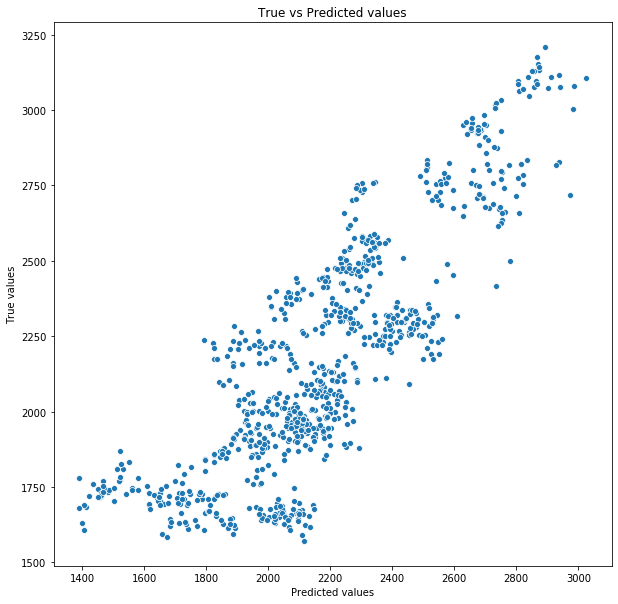

In [352]:
y_train_preds = lr_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2 коэфф детерминация: 	0.736
MAE:	173.996
MSE:	42206.445


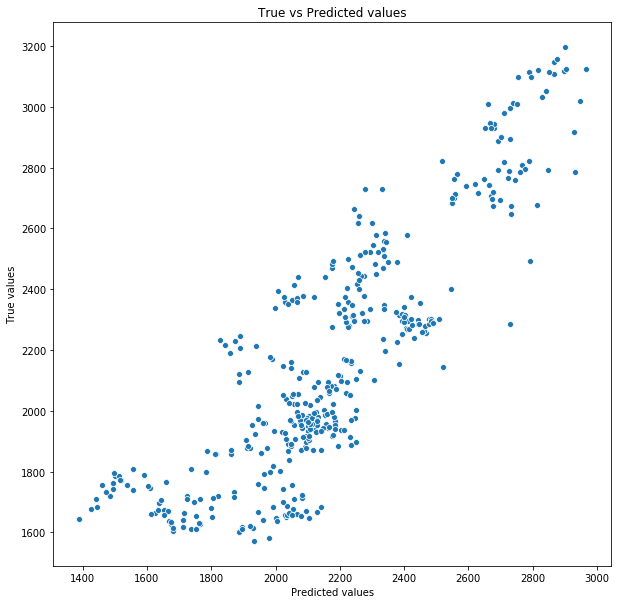

In [353]:
y_test_preds = lr_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

# Вывод:
    
в ходе работы были проаназилированы данные за период с 2015-01-01 по 2020-03-31
произведена статистическая оценка зависимости индекса Мосбиржи от цены на нефть и цены на золото
построено уравнение линейой регресии. сами данных присутствует линейная зависимость.
Вполне возможно что использование других методов регресии дадут более качественный результат.
 